In [1]:
import importlib
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def check_and_install(libraries):
    for lib in libraries:
        try:
            importlib.import_module(lib)
            print(f"{lib} is already installed.")
        except ImportError:
            print(f"{lib} is not installed. Installing now...")
            install_package(lib)
            print(f"{lib} has been successfully installed.")

# List of libraries to check and install
libraries_to_check = ['stable_baselines3', 'torch', 'matplotlib', 'gdown', 'gymnasium', 'tqdm','rich']

check_and_install(libraries_to_check)

2024-08-07 20:57:17.400520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 20:57:17.400588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 20:57:17.401896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 20:57:17.412783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 20:57:19.196260: W tensorflow/compiler/tf2

stable_baselines3 is already installed.
torch is already installed.
matplotlib is already installed.
gdown is already installed.
gymnasium is already installed.
tqdm is already installed.
rich is already installed.


In [2]:
import requests
import os

# URL of the raw file (note the change from blob to raw)
url = "https://github.com/kora-labs/chromax/raw/master/chromax/sample_data/genome.npy"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Get the filename from the URL
    filename = os.path.basename(url)
    
    # Save the content to a file in the current working directory
    with open(filename, 'wb') as f:
        f.write(response.content)
    
    print(f"File '{filename}' has been downloaded to the current working directory.")
else:
    print("Failed to download the file.")

File 'genome.npy' has been downloaded to the current working directory.


In [3]:
import numpy as np

genome = np.load('genome.npy', allow_pickle=True)
reshaped_genome = np.transpose(genome, (0, 2, 1))


In [4]:
import torch
from typing import Optional, Dict
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from IPython.display import clear_output
import matplotlib.colors as mcolors

import gymnasium as gym
import torch
import numpy as np
from collections import defaultdict
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure
tensorboard_log = './ppotb'
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Breeding Simulator

In [6]:
"""

This breeding simulation will simulate a single additive trait.

1) we will init a randomized population of size (config.starting_parents, 2, config.n_markers) with 0/1 tensor
2) we will use this starting population to sample the marker effects for our additive trait, which is scaled to be 0/1 mean/var for the population
3) we will store the founder_pop and their founder_phentypes

"""





## BREEDING SIMULATOR
    
class Genome:
    def __init__(self, n_markers: int):
        self.ploidy: int = 2
        self.n_markers: int = n_markers

    def __repr__(self) -> str:
        return f"Genome(ploidy={self.ploidy}, n_markers={self.n_markers})"

class Population:
    def __init__(self, pop_size: int, haplotypes:torch.tensor, genome: Genome, device: torch.device):
        self.pop_size: int = pop_size
        self.genome: Genome = genome
        self.haplotypes: torch.Tensor = haplotypes
        self.device: torch.device = device
        
    def to(self, device: torch.device) -> 'Population':
        self.device = device
        self.haplotypes = self.haplotypes.to(device)
        return self

    def __repr__(self) -> str:
        return f"Population(pop_size={self.pop_size}, genome={self.genome}, device={self.device})"

class Trait:
    def __init__(self, genome: Genome, population: Population, target_mean: float = 0.0, target_variance: float = 1):
        self.genome: Genome = genome
        self.device: torch.device = population.device
        self.target_mean: float = target_mean
        self.target_variance: float = target_variance

        # Use torch.randn with a generator for reproducibility
        generator = torch.Generator(device=self.device)
        generator.manual_seed(torch.initial_seed())  # Use the seed set by torch.manual_seed()
        raw_effects = torch.randn(genome.n_markers, device=self.device, generator=generator)

        centered_effects = raw_effects - raw_effects.mean()
        dosages = population.haplotypes.sum(dim=1)
        founder_values = torch.einsum('ij,j->i', dosages, centered_effects)
        founder_mean = founder_values.mean()
        founder_var = founder_values.var()

        scaling_factor = torch.sqrt(self.target_variance / founder_var)
        self.effects: torch.Tensor = centered_effects * scaling_factor
        self.intercept: torch.Tensor = (torch.tensor(self.target_mean, device=self.device) - founder_mean).detach()

    def to(self, device: torch.device) -> 'Trait':
        self.device = device
        self.effects = self.effects.to(device)
        self.intercept = self.intercept.to(device)
        return self

    def __repr__(self) -> str:
        return f"Trait(target_mean={self.target_mean}, target_variance={self.target_variance}, device={self.device})"


"""
The logic of the breeding simulation. Meiosis(Recombination) + Crossing

All operate on tensors
"""
@staticmethod
def meiosis(selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
    """ takes a tensor of parent genomes, (selected_haplotypes) and generates gametes for each parent"""
    num_parents, ploidy, num_markers = selected_haplotypes.shape

    # Repeat each parent's haplotypes num_gametes_per_parent times
    expanded_haplotypes = selected_haplotypes.repeat_interleave(num_gametes_per_parent, dim=0)

    # The rest of the function remains largely the same, but operates on the expanded haplotypes
    total_gametes = num_parents * num_gametes_per_parent

    crossover_points = torch.randint(1, num_markers, (total_gametes, num_crossovers), device=selected_haplotypes.device, generator=torch.Generator(device=selected_haplotypes.device).manual_seed(torch.initial_seed()))
    crossover_points, _ = torch.sort(crossover_points, dim=1)

    crossover_mask = torch.zeros((total_gametes, num_markers), dtype=torch.bool, device=selected_haplotypes.device)
    crossover_mask.scatter_(1, crossover_points, 1)
    crossover_mask = torch.cumsum(crossover_mask, dim=1) % 2 == 1

    crossover_mask = crossover_mask.unsqueeze(1).expand(-1, ploidy, -1)

    start_chromosome = torch.randint(0, ploidy, (total_gametes, 1), device=selected_haplotypes.device)
    start_mask = start_chromosome.unsqueeze(-1).expand(-1, -1, num_markers)

    final_mask = crossover_mask ^ start_mask.bool()

    offspring_haplotypes = torch.where(final_mask, expanded_haplotypes, expanded_haplotypes.roll(shifts=1, dims=1))

    # Return only the first haplotype for each meiosis event
    return offspring_haplotypes[:, 0, :]

@staticmethod
def random_cross(gamete_tensor: torch.Tensor, total_crosses: int) -> torch.Tensor:
    """ takes output from meiosis (gamete tensor) and outputs offspring """
    num_gametes, n_markers = gamete_tensor.shape

    # Double the gamete tensor until we have enough for the total crosses
    while num_gametes < 2 * total_crosses:
        gamete_tensor = torch.cat([gamete_tensor, gamete_tensor], dim=0)
        num_gametes *= 2

    # Randomly select gametes for crossing
    gamete_indices = torch.randperm(num_gametes, device=gamete_tensor.device)
    parent1_indices = gamete_indices[:total_crosses]
    parent2_indices = gamete_indices[total_crosses:2*total_crosses]

    # Create the new population haplotype tensor
    new_population = torch.stack([
        gamete_tensor[parent1_indices],
        gamete_tensor[parent2_indices]
    ], dim=1)

    return new_population
    

@staticmethod
def score_population(haplotypes: torch.Tensor, trait: Trait, h2: float = 1.0, founder_mean: float = 0, founder_std: float = 1):
    dosages = haplotypes.sum(dim=1)
    breeding_values = torch.einsum('ij,j->i', dosages, trait.effects)
    bv_var = breeding_values.var()

    if bv_var == 0 or h2 >= 1:
        phenotypes = breeding_values
    else:
        env_variance = (1 - h2) / (h2 * bv_var.item()+.001)
        env_std = torch.sqrt(torch.tensor(env_variance, device=trait.device))
        env_effects = torch.randn_like(breeding_values) * env_std
        phenotypes = breeding_values + env_effects + trait.intercept

    # Normalize phenotypes
    normalized_phenotypes = (phenotypes - founder_mean) / founder_std

    return breeding_values, normalized_phenotypes



import torch
import numpy as np

class SimParams:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.genome = Genome(config.n_markers)

        # Load and prepare genome
        genome = np.load('genome.npy')
        reshaped_genome = np.transpose(genome, (0, 2, 1))
        reshaped_genome = torch.tensor(reshaped_genome, device=self.device).float()
        
        # Sample parents
        random_indices = torch.randperm(reshaped_genome.shape[0])[:config.starting_parents]
        parents = reshaped_genome[random_indices]
        
        # Sample markers
        random_indices = torch.randperm(parents.shape[2])[:config.n_markers]
        parents = parents[:,:,random_indices]

        f1_gametes = meiosis(parents, num_crossovers=config.num_crossovers, num_gametes_per_parent=config.pop_size)
        f1 = random_cross(gamete_tensor=f1_gametes, total_crosses=config.pop_size)

        self.founder_pop = Population(config.pop_size, f1, self.genome, self.device)
        self.trait = Trait(self.genome, self.founder_pop)
        # Calculate founder population statistics
        founder_bv, founder_phenotypes = score_population(self.founder_pop.haplotypes, self.trait, h2=self.config.h2)
        self.founder_mean = founder_phenotypes.mean().item()
        self.founder_std = founder_phenotypes.std().item()

        # Perform burn-in
        new_pop, new_mean = self.burn_in(num_generations=config.burnin_years, genetic_variance_threshold=config.burnin_gvt)
        
        # Update founder population
        self.founder_pop.haplotypes = new_pop
        
        # Calculate normalization parameters based on burn-in population
        _, burn_in_phenotypes = score_population(new_pop, self.trait, h2=self.config.h2)
        self.normalization_mean = burn_in_phenotypes.mean().item()
        self.normalization_std = burn_in_phenotypes.std().item()
        
        # Update trait intercept
        self.trait.intercept = torch.tensor(self.trait.target_mean, device=self.trait.device)

        
    def burn_in(self, num_generations=50, h2=0.1, selection_intensity=0.9, mutation_rate=0.001, genetic_variance_threshold=.4):
        current_pop = self.founder_pop.haplotypes
        current_size = self.config.pop_size

        for generation in range(num_generations):
            # Score the current population
            breeding_values, phenotypes = score_population(current_pop, self.trait, self.trait.intercept)

            # Calculate genetic variance
            genetic_variance = breeding_values.var().item()

            # Introduce mutations if genetic variance is below the threshold
            if genetic_variance < genetic_variance_threshold:
                mutation_mask = torch.rand_like(current_pop) < mutation_rate
                current_pop = torch.where(mutation_mask, 1 - current_pop, current_pop)
            else:
                # Select top individuals
                num_selected = max(int(current_size * selection_intensity), 2)  # Ensure at least 2 parents
                selection = torch.topk(phenotypes, num_selected).indices
                selected_parents = current_pop[selection]

                # Create next generation
                gametes = meiosis(selected_parents, num_gametes_per_parent=self.config.pop_size // num_selected + 1)
                current_pop = random_cross(gametes, total_crosses=self.config.pop_size)

            if generation % 10 == 0 or generation == num_generations - 1:
                print(f"Generation {generation + 1}: "
                    f"Max phenotype = {phenotypes.max().item():.4f}, "
                    f"Max breeding value = {breeding_values.max().item():.4f}, "
                    f"Genetic variance = {genetic_variance:.4f}")

        # Calculate new mean
        final_breeding_values, _ = score_population(current_pop, self.trait, h2=1.0)
        new_mean = final_breeding_values.mean().item()

        return current_pop, new_mean



import numpy as np
import torch
from tqdm import tqdm

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch


import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from collections import defaultdict
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback



class GeneralizedVisualizationCallback(BaseCallback):
    def __init__(self, verbose=0, log_freq=2000, window_size=50, target_phenotype=None, best_action=None):
        super().__init__(verbose)
        self.data = defaultdict(lambda: defaultdict(list))
        self.log_freq = log_freq
        self.excluded_metrics = ['TimeLimit.truncated', 'current_generation']
        self.target_phenotype = target_phenotype
        self.best_action = best_action
        self.window_size = window_size

    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        obs = self.locals['new_obs']
        
        current_generation = info['current_generation']
        
        # Track all scalar values from the observation space
        for key, value in obs.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)
        
        # Also track any scalar values from the info dict
        for key, value in info.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)

        if self.num_timesteps % self.log_freq == 0:
            self.visualize()

        return True

    def visualize(self):
        num_metrics = len(self.data)
        fig, axes = plt.subplots(num_metrics, 1, figsize=(16, 6*num_metrics), sharex=True)
        if num_metrics == 1:
            axes = [axes]

        for idx, (metric, generations) in enumerate(self.data.items()):
            ax = axes[idx]
            num_generations = len(generations)
            colors = plt.cm.BuPu(np.linspace(0, 1, num_generations))

            for i, (generation, values) in enumerate(generations.items()):
                if len(values) == 0:
                    continue  # Skip empty data

                steps = np.arange(len(values))

                # Dynamically adjust window size
                effective_window = min(self.window_size, len(values))
                if effective_window < 2:
                    effective_window = 2  # Minimum window size

                # Calculate rolling moving average with adjusted window size
                rolling_avg = np.convolve(values, np.ones(effective_window), 'valid') / effective_window
                rolling_steps = steps[effective_window-1:]

                ax.plot(rolling_steps, rolling_avg, label=f'Generation {generation}', color=colors[i])
                ax.set_title(f'{metric.capitalize()} per Generation')
                ax.set_ylabel(f'Rolling Avg {metric.capitalize()}')
                ax.grid(True)

            # Add target_phenotype line for max_phenotype chart
            if metric == 'max_phenotype' and self.target_phenotype is not None:
                ax.axhline(y=self.target_phenotype, color='r', linestyle='--', label='Target Phenotype')
            # Add best_action line for selection_intensity chart
            if metric == 'selection_intensity' and self.best_action is not None:
                best_action_intensity = self.best_action[0] if isinstance(self.best_action, (list, np.ndarray)) else self.best_action
                # Remove the conversion here, as best_action should already be a selection intensity
                ax.axhline(y=best_action_intensity, color='r', linestyle='--', label='Best Constant Action')
                # Set y-axis limits for selection_intensity
            if metric == 'selection_intensity':
                ax.set_ylim(0, 1)
                

        axes[-1].set_xlabel('Steps within Generation')
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

        
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

class BreedingEnv(gym.Env):
    def __init__(self, sim_params: SimParams):
        super(BreedingEnv, self).__init__()
        
        self.SP = sim_params
        self.max_generations = sim_params.config.max_generations
        self.current_generation = 0
        self.current_pop = sim_params.founder_pop.haplotypes
        self.selection_intensities = []
        self.founder_mean = sim_params.founder_mean
        self.founder_std = sim_params.founder_std
        
        # New attribute to store sum of actions
        self.action_sum = 0.0

        # Define action and observation spaces
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            'remaining_generations': spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'genetic_variance': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'average_action': spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
        })

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.current_pop = self.SP.founder_pop.haplotypes
        self.selection_intensities = []
        self.action_sum = 0.0  # Reset action sum
        return self._get_obs(), {}

    def step(self, action):
        # Convert action to selection intensity
        selection_intensity = (action[0] + 1) / 2 * 0.98 + 0.01  # Maps [-1, 1] to [0.01, 0.99]
        self.selection_intensities.append(selection_intensity)
        
        # Update action sum
        self.action_sum += selection_intensity
        
        # Score the current population
        breeding_values, phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        
        # Select top individuals
        num_selected = max(int(self.SP.config.pop_size * selection_intensity), 2)
        selection = torch.topk(phenotypes, num_selected).indices
        selected_parents = self.current_pop[selection]
        
        # Create next generation
        gametes = meiosis(selected_parents, num_gametes_per_parent=self.SP.config.pop_size // num_selected + 1)
        self.current_pop = random_cross(gametes, total_crosses=self.SP.config.pop_size)
        
        # Update generation count
        self.current_generation += 1
        
        # Calculate reward
        new_breeding_values, new_phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        # Check if done
        done = self.current_generation >= self.max_generations

        if self.SP.config.sparse_reward:
            if done:
                reward = new_breeding_values.mean().item() - self.founder_mean
            else:
                reward = 0
        else:
            reward = new_breeding_values.mean().item() - breeding_values.mean().item()


        # Prepare observation
        observation = self._get_obs()

        # Prepare info dictionary
        info = {
            'max_phenotype': new_phenotypes.mean().item(),
            'current_generation': self.current_generation,
            'genetic_variance': new_phenotypes.var().item(),
            'selection_intensity': selection_intensity
        }

        return observation, reward, done, False, info

    def _get_obs(self):
        breeding_values, _ = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        genetic_variance = breeding_values.var().item()
        remaining_generations = (self.max_generations - self.current_generation) / self.max_generations
        average_action = self.action_sum / (self.current_generation + 1) if self.current_generation > 0 else 0.0
        
        return {
            'remaining_generations': np.array([remaining_generations], dtype=np.float32),
            'genetic_variance': np.array([genetic_variance], dtype=np.float32),
            'average_action': np.array([average_action], dtype=np.float32)
        }



@staticmethod
def score_population(haplotypes: torch.Tensor, trait: Trait, h2: float = 1.0, norm_mean: float = 0, norm_std: float = 1):
    dosages = haplotypes.sum(dim=1)
    breeding_values = torch.einsum('ij,j->i', dosages, trait.effects)
    bv_var = breeding_values.var()

    if bv_var == 0 or h2 >= 1:
        phenotypes = breeding_values
    else:
        env_variance = (1 - h2) / h2 * bv_var.item()
        env_std = torch.sqrt(torch.tensor(env_variance, device=trait.device))
        env_effects = torch.randn_like(breeding_values) * env_std
        phenotypes = breeding_values + env_effects + trait.intercept

    # Normalize phenotypes
    normalized_phenotypes = (phenotypes - norm_mean) / norm_std

    return breeding_values, normalized_phenotypes

@dataclass
class SimulationConfig:
    #training
    total_timesteps: int = 2000
    seed: int = 100
    max_generations: int= 50
    #breeding sim parameters
    n_markers: int = 500
    starting_parents: int = 200
    pop_size: int = 500
    h2: float = 0.5
    num_crossovers: int=3
    sparse_reward: bool=False
    #burnin
    burnin_years : int =  10
    burnin_gvt : float = .4


class EnhancedBreedingEnv(gym.Env):
    def __init__(self, sim_params: SimParams):
        super(EnhancedBreedingEnv, self).__init__()
        
        self.SP = sim_params
        self.max_generations = sim_params.config.max_generations
        self.current_generation = 0
        self.current_pop = sim_params.founder_pop.haplotypes
        self.selection_intensities = []
        self.founder_mean = sim_params.founder_mean
        self.founder_std = sim_params.founder_std
        self.action_sum = 0.0

        # Define action and observation spaces
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            'remaining_generations': spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'genetic_variance': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'average_action': spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'current_mean_phenotype': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'current_max_phenotype': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'phenotypic_variance': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'heritability': spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'genetic_gain': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
        })

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.current_pop = self.SP.founder_pop.haplotypes
        self.selection_intensities = []
        self.action_sum = 0.0
        self.last_mean_breeding_value = None
        return self._get_obs(), {}

    def step(self, action):
        selection_intensity = (action[0] + 1) / 2 * 0.98 + 0.01
        self.selection_intensities.append(selection_intensity)
        self.action_sum += selection_intensity
        
        breeding_values, phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        
        num_selected = max(int(self.SP.config.pop_size * selection_intensity), 2)
        selection = torch.topk(phenotypes, num_selected).indices
        selected_parents = self.current_pop[selection]
        
        gametes = meiosis(selected_parents, num_gametes_per_parent=self.SP.config.pop_size // num_selected + 1)
        self.current_pop = random_cross(gametes, total_crosses=self.SP.config.pop_size)
        
        self.current_generation += 1
        
        new_breeding_values, new_phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        done = self.current_generation >= self.max_generations

        if self.SP.config.sparse_reward:
            reward = new_breeding_values.max().item() - self.founder_mean if done else 0
        else:
            reward = new_breeding_values.max().item() - breeding_values.max().item()

        observation = self._get_obs()
        info = {
            'max_phenotype': new_phenotypes.max().item(),
            'current_generation': self.current_generation,
            'genetic_variance': new_breeding_values.var().item(),
            'selection_intensity': selection_intensity
        }

        return observation, reward, done, False, info

    def _get_obs(self):
        breeding_values, phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        genetic_variance = breeding_values.var().item()
        phenotypic_variance = phenotypes.var().item()
        
        current_mean_breeding_value = breeding_values.mean().item()
        genetic_gain = (current_mean_breeding_value - self.last_mean_breeding_value) if self.last_mean_breeding_value is not None else 0
        self.last_mean_breeding_value = current_mean_breeding_value

        return {
            'remaining_generations': np.array([(self.max_generations - self.current_generation) / self.max_generations], dtype=np.float32),
            'genetic_variance': np.array([genetic_variance], dtype=np.float32),
            'average_action': np.array([self.action_sum / (self.current_generation + 1)], dtype=np.float32),
            'current_mean_phenotype': np.array([phenotypes.mean().item()], dtype=np.float32),
            'current_max_phenotype': np.array([phenotypes.max().item()], dtype=np.float32),
            'phenotypic_variance': np.array([phenotypic_variance], dtype=np.float32),
            'heritability': np.array([genetic_variance / (phenotypic_variance+.01)], dtype=np.float32),
            'genetic_gain': np.array([genetic_gain], dtype=np.float32),
        }


import numpy as np
import matplotlib.pyplot as plt

class EnhancedBreedingEnv(gym.Env):
    def __init__(self, sim_params: SimParams):
        super(EnhancedBreedingEnv, self).__init__()
        
        self.SP = sim_params
        self.max_generations = sim_params.config.max_generations
        self.current_generation = 0
        self.current_pop = sim_params.founder_pop.haplotypes
        self.selection_intensities = []
        self.founder_mean = sim_params.founder_mean
        self.founder_std = sim_params.founder_std
        self.action_sum = 0.0

        # Define action and observation spaces
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            'remaining_generations': spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'genetic_variance': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'average_action': spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'current_mean_phenotype': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'current_max_phenotype': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'phenotypic_variance': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'heritability': spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'genetic_gain': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
        })

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.current_pop = self.SP.founder_pop.haplotypes
        self.selection_intensities = []
        self.action_sum = 0.0
        self.last_mean_breeding_value = None
        return self._get_obs(), {}

    def step(self, action):
        selection_intensity = (action[0] + 1) / 2 * 0.98 + 0.01
        self.selection_intensities.append(selection_intensity)
        self.action_sum += selection_intensity
        
        breeding_values, phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        
        num_selected = max(int(self.SP.config.pop_size * selection_intensity), 2)
        selection = torch.topk(phenotypes, num_selected).indices
        selected_parents = self.current_pop[selection]
        
        gametes = meiosis(selected_parents, num_gametes_per_parent=self.SP.config.pop_size // num_selected + 1)
        self.current_pop = random_cross(gametes, total_crosses=self.SP.config.pop_size)
        
        self.current_generation += 1
        
        new_breeding_values, new_phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        done = self.current_generation >= self.max_generations

        if self.SP.config.sparse_reward:
            reward = new_breeding_values.max().item() - self.founder_mean if done else 0
        else:
            reward = new_breeding_values.max().item() - breeding_values.max().item()

        observation = self._get_obs()
        info = {
            'max_phenotype': new_phenotypes.max().item(),
            'current_generation': self.current_generation,
            'genetic_variance': new_breeding_values.var().item(),
            'selection_intensity': selection_intensity
        }

        return observation, reward, done, False, info

    def _get_obs(self):
        breeding_values, phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        genetic_variance = breeding_values.var().item()
        phenotypic_variance = phenotypes.var().item()
        
        current_mean_breeding_value = breeding_values.mean().item()
        genetic_gain = (current_mean_breeding_value - self.last_mean_breeding_value) if self.last_mean_breeding_value is not None else 0
        self.last_mean_breeding_value = current_mean_breeding_value

        return {
            'remaining_generations': np.array([(self.max_generations - self.current_generation) / self.max_generations], dtype=np.float32),
            'genetic_variance': np.array([genetic_variance], dtype=np.float32),
            'average_action': np.array([self.action_sum / (self.current_generation + 1)], dtype=np.float32),
            'current_mean_phenotyp  e': np.array([phenotypes.mean().item()], dtype=np.float32),
            'current_max_phenotype': np.array([phenotypes.max().item()], dtype=np.float32),
            'phenotypic_variance': np.array([phenotypic_variance], dtype=np.float32),
            'heritability': np.array([genetic_variance / (phenotypic_variance+.01)], dtype=np.float32),
            'genetic_gain': np.array([genetic_gain], dtype=np.float32),
        }


def run_constant_action_baseline_analysis(env, num_episodes=10, num_actions = 20):
    def run_constant_action_baseline(env, action, num_episodes):
        results = []
        for _ in range(num_episodes):
            obs, _ = env.reset()
            done = False
            episode_reward = 0
            max_phenotypes = []
            genetic_variances = []
            
            while not done:
                obs, reward, done, _, info = env.step(np.array([action]))
                episode_reward += reward
                max_phenotypes.append(info['max_phenotype'])
                genetic_variances.append(info['genetic_variance'])
            
            results.append({
                'total_reward': episode_reward,
                'max_phenotypes': max_phenotypes,
                'genetic_variances': genetic_variances
            })
        
        return results

    # Define a range of constant actions to test
    actions_to_test = np.linspace(-1, 1, num_actions)

    # Collect baseline results
    baseline_results = {}
    best_action = None
    best_max_phenotype = float('-inf')
    best_avg_reward = float('-inf')

    for action in actions_to_test:
        baseline_results[action] = run_constant_action_baseline(env, action, num_episodes)
        
        # Calculate average max phenotype and average total reward for this action
        avg_max_phenotype = np.mean([max(r['max_phenotypes']) for r in baseline_results[action]])
        avg_total_reward = np.mean([r['total_reward'] for r in baseline_results[action]])
        
        # Update best action if this action performs better
        if avg_max_phenotype > best_max_phenotype:
            best_action = action
            best_max_phenotype = avg_max_phenotype
            best_avg_reward = avg_total_reward

    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    n_bins = len(actions_to_test)
    cmap = plt.get_cmap('PRGn')

    # Determine which actions to label (10 evenly spaced)
    label_indices = np.linspace(0, len(actions_to_test) - 1, 10, dtype=int)

    for i, (action, results) in enumerate(baseline_results.items()):
        selection_intensity = (action + 1) / 2 * 0.98 + 0.01
        avg_max_phenotypes = np.mean([r['max_phenotypes'] for r in results], axis=0)
        avg_genetic_variances = np.mean([r['genetic_variances'] for r in results], axis=0)
        avg_total_reward = np.mean([r['total_reward'] for r in results])
        
        color = cmap(i / n_bins)
        
        label = f'Action {action:.2f} (SI: {selection_intensity:.2f})' if i in label_indices else None
        ax1.plot(avg_max_phenotypes, label=label, color=color)
        ax2.plot(avg_genetic_variances, label=label, color=color)
        ax3.bar(i, avg_total_reward, color=color)  # Use index i as x-coordinate

    # Add horizontal line for best max phenotype in ax1
    ax1.axhline(y=best_max_phenotype, color='r', linestyle='--', label=f'Best Phenotype: {best_max_phenotype:.2f}')

    ax1.set_title('Average Max Phenotype over Generations')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Max Phenotype')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax2.set_title('Average Genetic Variance over Generations')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Genetic Variance')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax3.set_title('Average Total Reward')
    ax3.set_xlabel('Action')
    ax3.set_ylabel('Total Reward')

    # Find the best action
    best_action, best_results = max(baseline_results.items(), key=lambda x: max(r['max_phenotypes'][-1] for r in x[1]))
    best_index = list(baseline_results.keys()).index(best_action)

    # Calculate the Selection Intensity for the best action
    best_selection_intensity = (best_action + 1) / 2 * 0.98 + 0.01

    # Add vertical line for best action
    ax3.axvline(x=best_index, color='r', linestyle='--', 
                label=f'Best Action: {best_action:.2f} (SI: {best_selection_intensity:.2f})')

    # Clean up x-axis for ax3
    x_ticks = np.linspace(0, len(actions_to_test) - 1, 10, dtype=int)
    ax3.set_xticks(x_ticks)
    ax3.set_xticklabels([f'{actions_to_test[i]:.2f}' for i in x_ticks], rotation=45, ha='right')

    # Add legend to ax3
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

    # Print average total rewards and best action information
    print("Average Total Rewards:")
    for action, results in baseline_results.items():
        avg_reward = np.mean([r['total_reward'] for r in results])
        selection_intensity = (action + 1) / 2 * 0.98 + 0.01
        print(f"Action {action:.2f} (SI: {selection_intensity:.2f}): {avg_reward:.2f}")

    print("\nBest Action Information:")
    print(f"Best Action: {best_action:.2f}")
    print(f"Best Selection Intensity: {best_selection_intensity:.2f}")
    print(f"Best Max Phenotype: {best_max_phenotype:.2f}")
    print(f"Best Average Reward: {best_avg_reward:.2f}")

    return best_action, best_selection_intensity, best_max_phenotype, best_avg_reward

# Usage:

# config = SimulationConfig()
# SP = SimParams(config)
# breeder_env = BreedingEnv(SP)
# best_action, best_si, best_phenotype, best_reward = run_constant_action_baseline_analysis(breeder_env, num_actions=100,num_episodes=30)



In [8]:

# # Example usage in a simple loop
# obs, _ = env.reset()
# for _ in range(100):
#     action = env.action_space.sample()  # Replace with your RL agent's action
#     obs, reward, done, _, _ = env.step(action)
#     if done:
#         break

# Environment

/tmp/ipykernel_425/1028253513.py:447: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  env_std = torch.sqrt(torch.tensor(env_variance, device=trait.device))


Generation 1: Max phenotype = nan, Max breeding value = 3.4888, Genetic variance = 1.0000
Generation 10: Max phenotype = nan, Max breeding value = 3.5499, Genetic variance = 1.0777


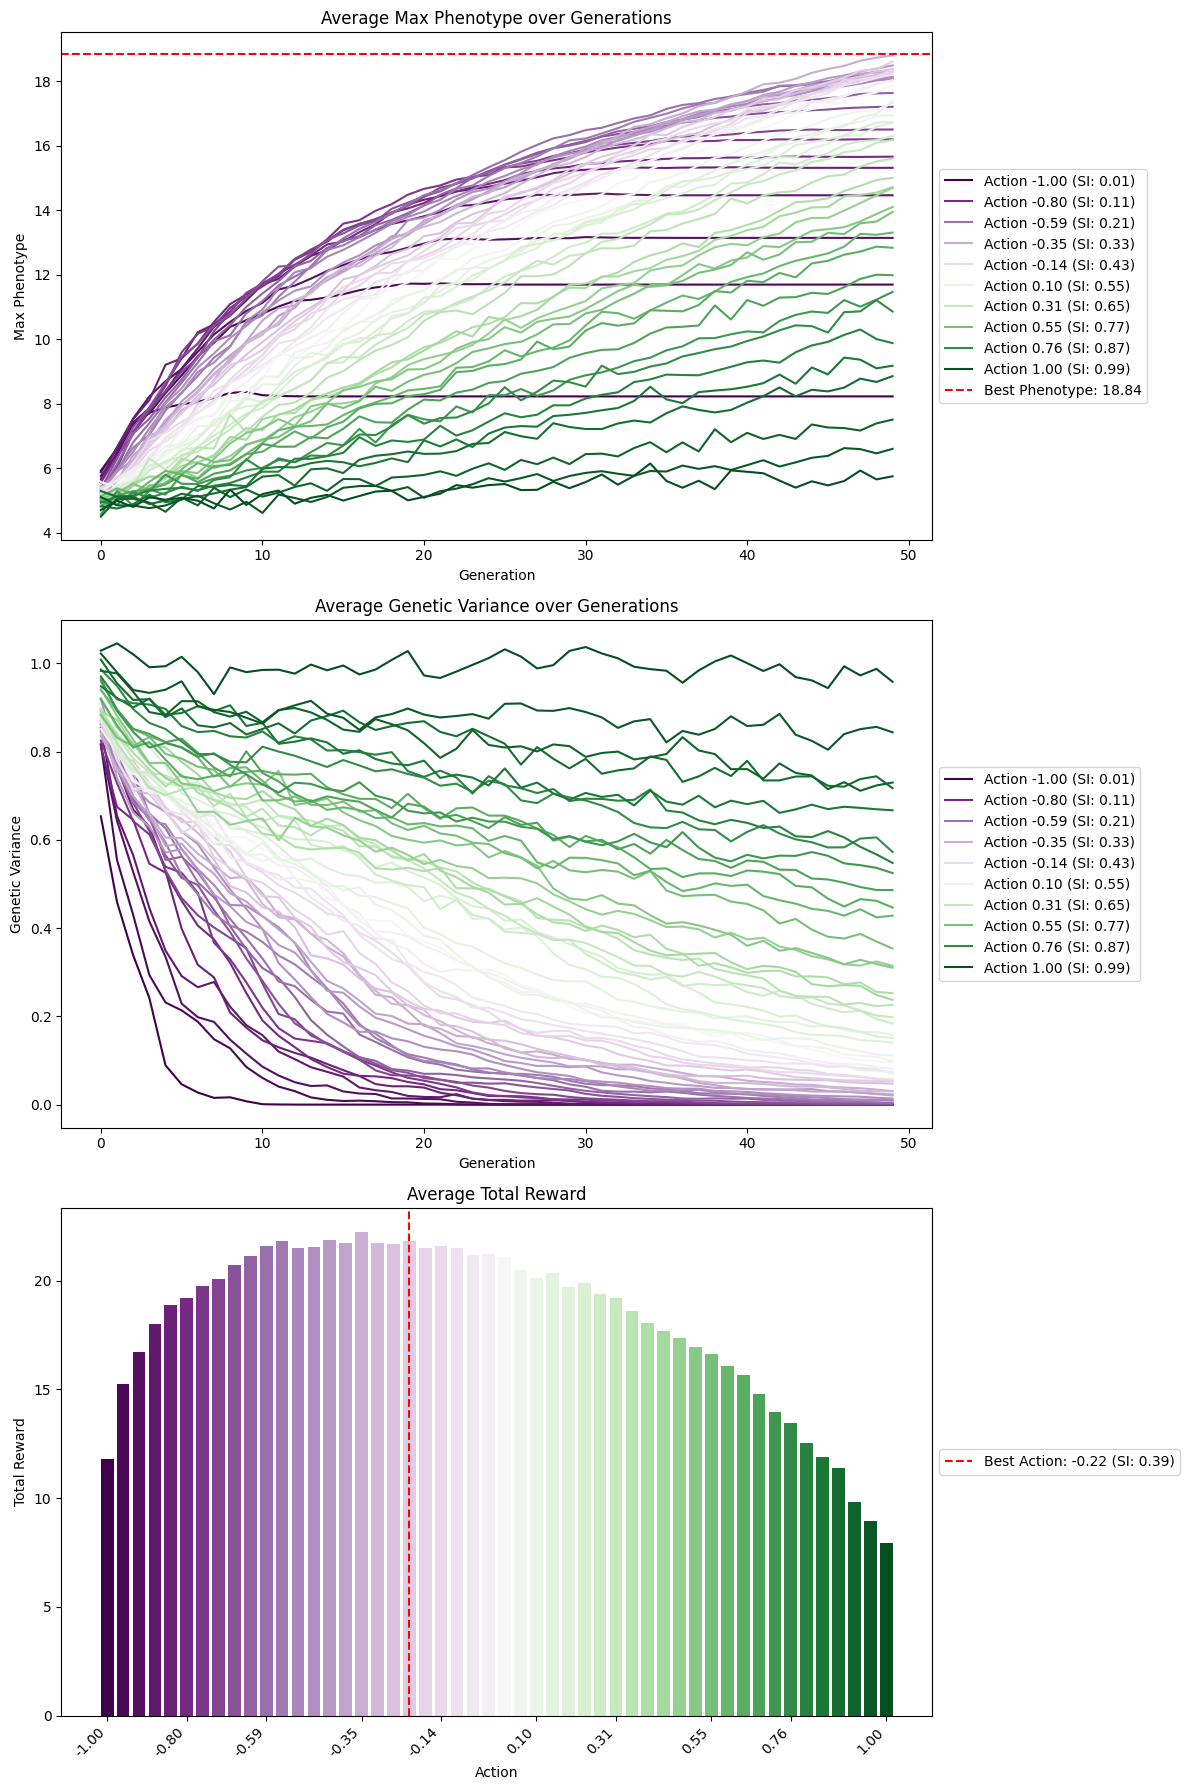

Average Total Rewards:
Action -1.00 (SI: 0.01): 11.79
Action -0.96 (SI: 0.03): 15.26
Action -0.92 (SI: 0.05): 16.71
Action -0.88 (SI: 0.07): 18.03
Action -0.84 (SI: 0.09): 18.88
Action -0.80 (SI: 0.11): 19.22
Action -0.76 (SI: 0.13): 19.76
Action -0.71 (SI: 0.15): 20.05
Action -0.67 (SI: 0.17): 20.73
Action -0.63 (SI: 0.19): 21.13
Action -0.59 (SI: 0.21): 21.60
Action -0.55 (SI: 0.23): 21.81
Action -0.51 (SI: 0.25): 21.52
Action -0.47 (SI: 0.27): 21.54
Action -0.43 (SI: 0.29): 21.88
Action -0.39 (SI: 0.31): 21.75
Action -0.35 (SI: 0.33): 22.22
Action -0.31 (SI: 0.35): 21.71
Action -0.27 (SI: 0.37): 21.67
Action -0.22 (SI: 0.39): 21.84
Action -0.18 (SI: 0.41): 21.52
Action -0.14 (SI: 0.43): 21.58
Action -0.10 (SI: 0.45): 21.49
Action -0.06 (SI: 0.47): 21.19
Action -0.02 (SI: 0.49): 21.23
Action 0.02 (SI: 0.51): 21.06
Action 0.06 (SI: 0.53): 20.51
Action 0.10 (SI: 0.55): 20.11
Action 0.14 (SI: 0.57): 20.34
Action 0.18 (SI: 0.59): 19.73
Action 0.22 (SI: 0.61): 19.88
Action 0.27 (SI: 0.63)

In [10]:
from stable_baselines3 import PPO
config = SimulationConfig()
config.sparse_reward = True
config.max_generations=50
config.num_crossovers = 10
SP = SimParams(config)
breeder_env = EnhancedBreedingEnv(SP)
best_action, best_si, best_phenotype, best_reward = run_constant_action_baseline_analysis(breeder_env, num_actions=50)

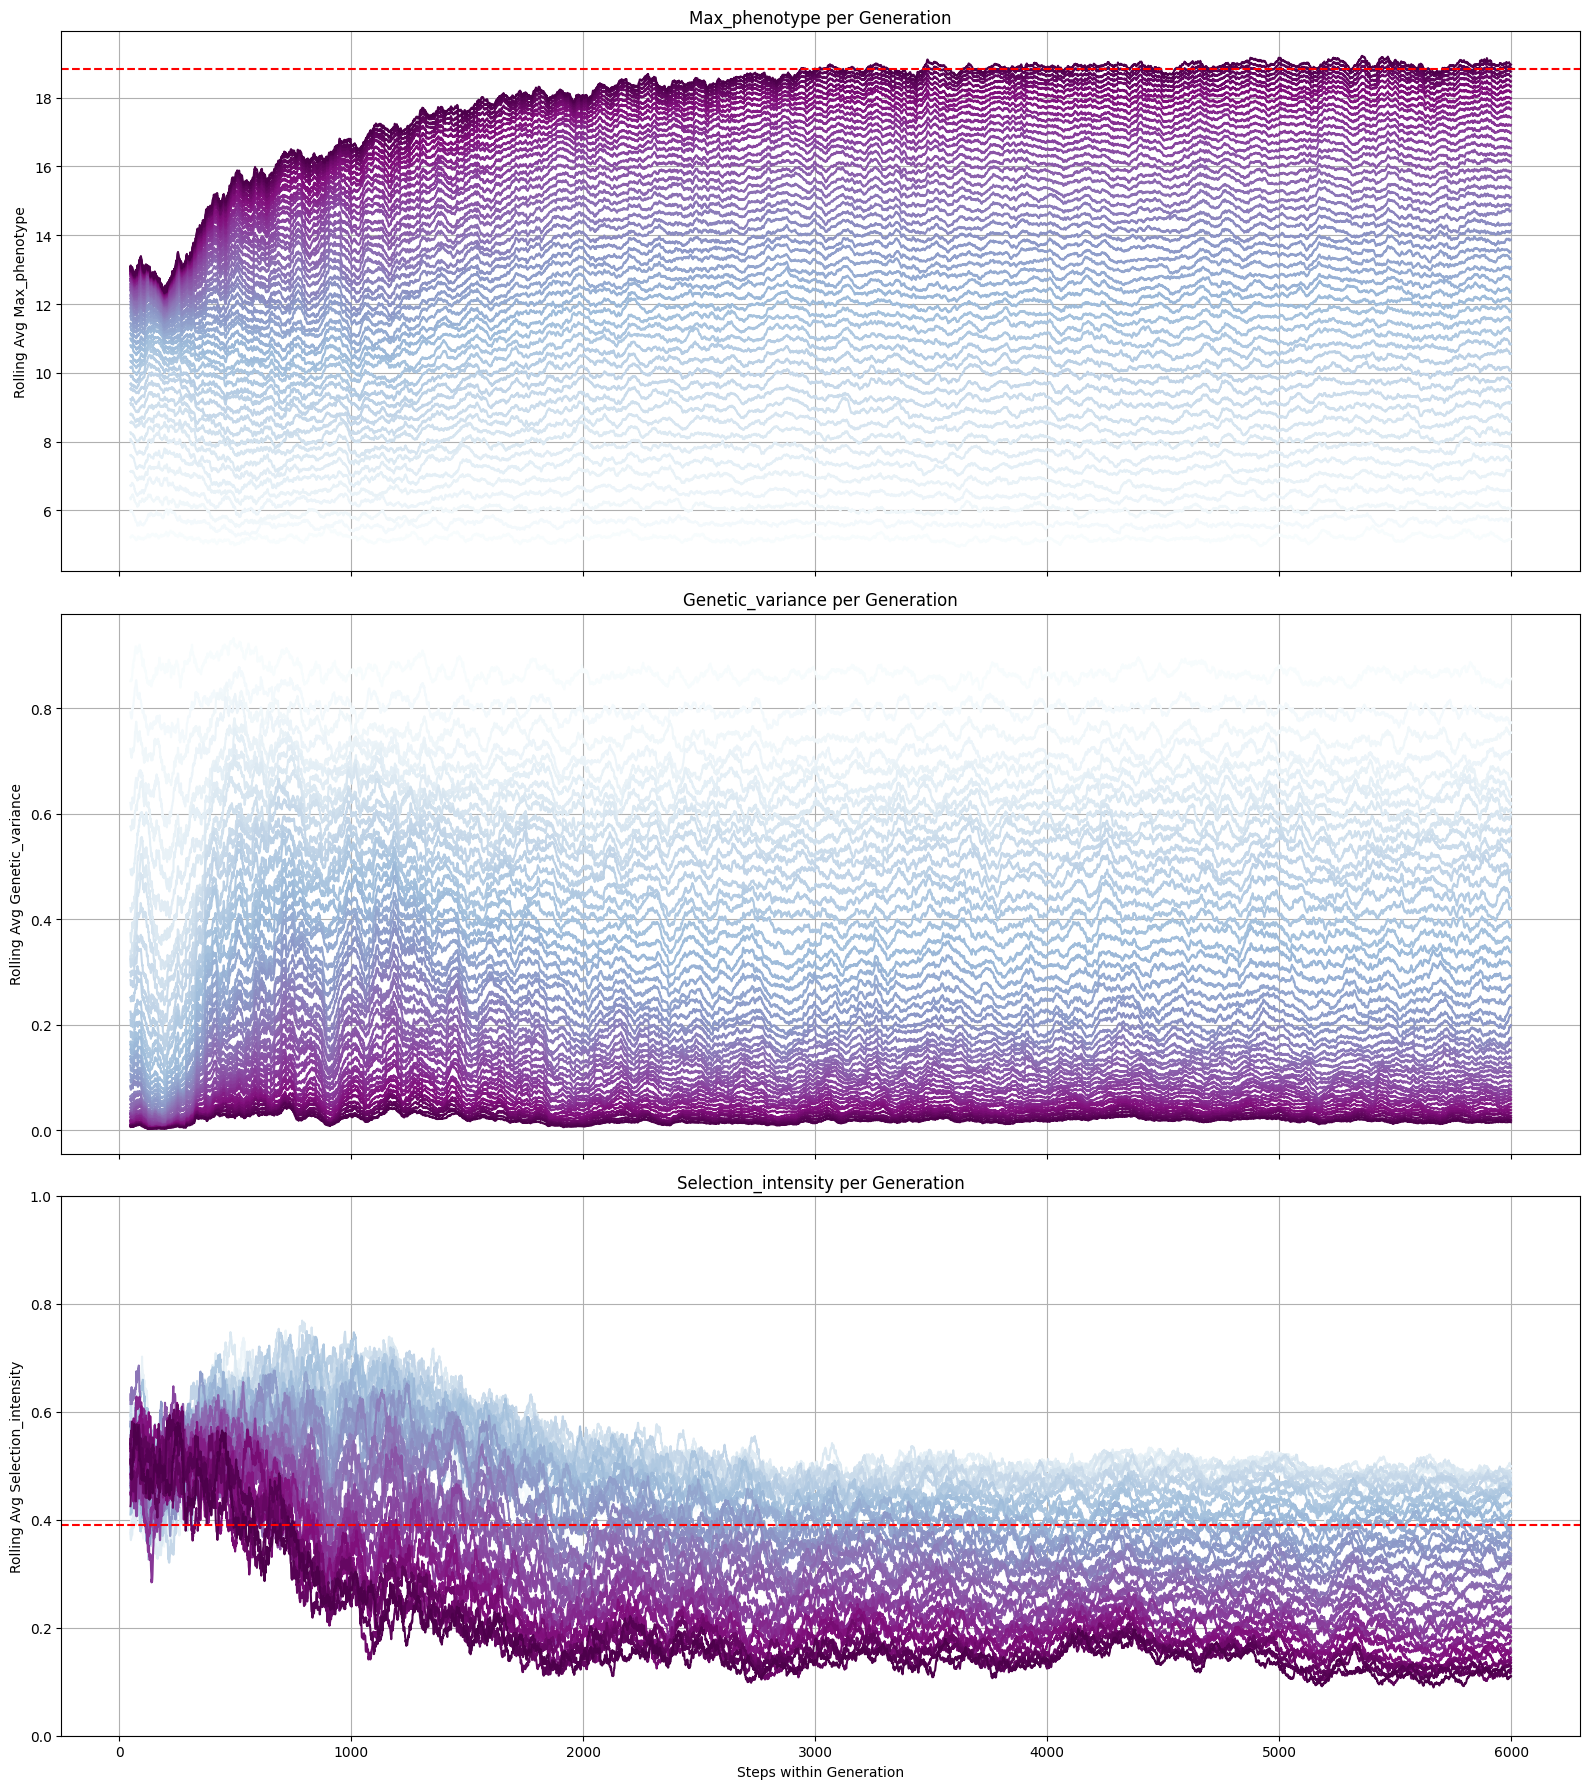

In [11]:

agent = PPO("MultiInputPolicy", breeder_env)
cb = GeneralizedVisualizationCallback(window_size=50,
    target_phenotype=float(best_phenotype), 
    best_action=[float(best_si)]
)
agent.learn(total_timesteps=300000 ,callback=cb)

## budget

In [113]:

class BudgetEnv(gym.Env):
    def __init__(self, sim_params: SimParams, starting_budget=100):
        super(BudgetEnv, self).__init__()
        
        self.SP = sim_params
        self.max_generations = sim_params.config.max_generations
        self.current_generation = 0
        self.current_pop = sim_params.founder_pop.haplotypes
        self.selection_intensities = []
        self.founder_mean = sim_params.founder_mean
        self.founder_std = sim_params.founder_std
        self.action_sum = 0.0
        self.starting_budget = starting_budget
        self.remaining_budget = starting_budget
        self.budget_history = []

        # Define action and observation spaces
        # Action space now includes selection intensity and budget allocation
        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            'genetic_variance': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'remaining_cycles': spaces.Box(low=0, high=self.max_generations, shape=(1,), dtype=np.float32),
            'remaining_budget': spaces.Box(low=0, high=self.starting_budget, shape=(1,), dtype=np.float32),
        })

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.current_pop = self.SP.founder_pop.haplotypes
        self.selection_intensities = []
        self.action_sum = 0.0
        self.remaining_budget = self.starting_budget
        self.budget_history = []
        return self._get_obs(), {}

    def step(self, action):
        # Extract selection intensity and budget allocation from action
        selection_intensity = (action[0] + 1) / 2 * 0.98 + 0.01
        budget_allocation = (action[1] + 1) / 2  # Normalized to [0, 1]

        # Calculate budget to spend
        budget_to_spend = self.remaining_budget * budget_allocation

        # Update remaining budget
        self.remaining_budget -= budget_to_spend
        self.budget_history.append(budget_to_spend)

        self.selection_intensities.append(selection_intensity)
        self.action_sum += selection_intensity
        
        breeding_values, phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        
        # Increase offspring based on budget spent (you'll need to define a function for this)
        num_offspring = self._calculate_offspring(self.SP.config.pop_size, budget_to_spend)
        num_selected = max(int(self.current_pop.shape[0] * selection_intensity), 2)
        
        selection = torch.topk(phenotypes, num_selected).indices
        selected_parents = self.current_pop[selection]
        
        gametes = meiosis(selected_parents, num_gametes_per_parent=num_offspring // num_selected + 1)
        self.current_pop = random_cross(gametes, total_crosses=num_offspring)
        
        self.current_generation += 1
        
        new_breeding_values, new_phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        done = self.current_generation >= self.max_generations

        # Reward function (you might need to adjust this based on your goals)
        if self.SP.config.sparse_reward:
            reward = new_breeding_values.max().item() - self.founder_mean if done else 0
        else:
            reward = new_breeding_values.max().item() - breeding_values.max().item()

        observation = self._get_obs()
        info = {
            'max_phenotype': new_phenotypes.max().item(),
            'current_generation': self.current_generation,
            'genetic_variance': new_breeding_values.var().item(),
            'selection_intensity': selection_intensity,
            'budget_spent': budget_to_spend
        }

        return observation, reward, done, False, info

    def _get_obs(self):
        breeding_values, _ = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        genetic_variance = breeding_values.var().item()
        remaining_cycles = self.max_generations - self.current_generation
        
        return {
            'genetic_variance': np.array([genetic_variance], dtype=np.float32),
            'remaining_cycles': np.array([remaining_cycles], dtype=np.float32),
            'remaining_budget': np.array([self.remaining_budget], dtype=np.float32),
        }

    def _calculate_offspring(self, base_offspring, budget_spent):
        # Define a function to calculate offspring based on budget spent
        # This is a placeholder, you'll need to implement a suitable logic here
        # For example, you could use a linear or exponential relationship
        return int(base_offspring + budget_spent * 1)  # Example: 10 offspring per budget unit

breeder_env = BudgetEnv(SP)

In [114]:
breeder_env.reset()

({'genetic_variance': array([0.65061235], dtype=float32),
  'remaining_cycles': array([50.], dtype=float32),
  'remaining_budget': array([100.], dtype=float32)},
 {})

In [115]:
breeder_env.step([0,0])

({'genetic_variance': array([0.60812485], dtype=float32),
  'remaining_cycles': array([49.], dtype=float32),
  'remaining_budget': array([50.], dtype=float32)},
 0,
 False,
 False,
 {'max_phenotype': 4.2090559005737305,
  'current_generation': 1,
  'genetic_variance': 0.608124852180481,
  'selection_intensity': 0.5,
  'budget_spent': 50.0})

In [116]:

agent = PPO("MultiInputPolicy", breeder_env)
agent.learn(total_timesteps=300000 )